# 多変数線形回帰

多変数線形回帰の例として，家の面積と寝室数から価格を予測する問題を扱う．

## データのロード

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [2]:
# 訓練データのロード
# 1列目：面積/feet^2，2列目：寝室数，3列目：価格
data = np.loadtxt('data/ex1data2.txt',delimiter=',')
X_unnorm_unext = np.array(data[:,0:-1]) # 特徴量を各都市について縦に並べた行列
y = np.array(data[:,-1]).reshape(-1,1) # ターゲットを各都市について縦に並べた列ベクトル
m, n = X_unnorm_unext.shape
print('訓練データの数：m =',m)
print('特徴量の数：n =',n)

訓練データの数：m = 47
特徴量の数：n = 2


訓練データをプロットする．

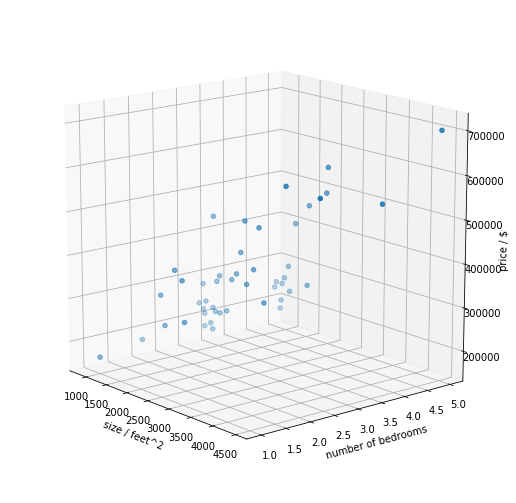

In [3]:
# 訓練データのプロット
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111,projection='3d')
ax.scatter3D(X_unnorm_unext[:,0],X_unnorm_unext[:,1],y)
ax.set_xlabel('size / feet^2')
ax.set_ylabel('number of bedrooms')
ax.set_zlabel('price / $')
ax.view_init(elev=15, azim=-40)

## 特徴量の規格化

特徴量が$x_j$ ($j=1,\dots ,n$) のように複数ある場合は，それらが異なるスケールを持っていることがあるため，すべての特徴量が大体同じ範囲に収まるように規格化した方が勾配法の効率が上がる．訓練データのラベルを$(d)$ ($d=1,\dots ,m$) と書くと，
$$
x_j^{(d)} \leftarrow\frac{x_j^{(d)} -\mu _j}{\sigma _j}
$$
を新たな特徴量として用いることで規格化できる．ただし，$\mu _j$, $\sigma _j$は$j$番目の特徴量の平均値，標準偏差である：
$$
\mu _j =\frac{1}{m} \sum _{d=1}^m x_j^{(d)} ,\quad\sigma _j =\sqrt{\frac{1}{m} \sum _{d=1}^m (x_j^{(d)} -\mu _j)^2} .
$$

In [4]:
# 特徴量の規格化
def featureNormalize(X_unnorm):
    mu = np.average(X_unnorm,axis=0)
    sigma = np.std(X_unnorm,axis=0)
    X_norm = (X_unnorm - mu) / sigma
    return(mu, sigma, X_norm)

In [5]:
mu, sigma, X_norm_unext = featureNormalize(X_unnorm_unext)

## 仮設とコストの定義

（規格化された）特徴量を$x_j^{(d)}$，パラメータを$\theta =(\theta ^0 ,\theta ^1 ,\dots ,\theta ^n)^\mathrm{T}$とすると，価格の仮設は$h_\theta (x_1^{(d)} ,\dots ,x_n^{(d)})=\theta ^0 +\theta ^1 x_1^{(d)} +\dots +\theta ^n x_n^{(d)}$と表される．ここで，0番目の特徴量として$x_0^{(d)} =1$を導入し，$x^{(d)} =(x_0^{(d)} ,x_1^{(d)} ,\dots ,x_n^{(d)})^\mathrm{T}$を特徴量ベクトルとすると，仮設は$h_\theta (x^{(d)})=(x^{(d)})^\mathrm{T} \theta$のように内積の形で書ける．

特徴量ベクトル$x^{(d)}$の転置をすべてのデータについて縦に並べた行列を
$$
X=
\begin{pmatrix}
(x^{(1)})^\mathrm{T} \\
\vdots\\
(x^{(m)})^\mathrm{T}
\end{pmatrix}
$$
とする．定義から$X$は$m\times (n+1)$行列であり，1列目の要素はすべて1である．

仮設$h_\theta (x^{(d)})$をすべてのデータについて縦に並べたベクトルは$X\theta$のように簡単に表せる．この仮設$X\theta$がターゲット$y=(y^{(1)} ,\dots ,y^{(m)})^\mathrm{T}$と近くなるようなパラメータ$\theta$を見つけたい．

In [6]:
# 新たな特徴量1を追加する関数
# X_unextは追加前のm*n行列，Xは追加後のm*(n+1)行列
def add1column(X_unext):
    X = np.hstack((np.ones((X_unext.shape[0],1)), X_unext))
    return(X)

In [7]:
X_norm = add1column(X_norm_unext)

コスト関数$J(\theta )$は，ターゲットに対する仮設の平均2乗誤差である：
$$
J(\theta )=\frac{1}{2m} \sum _{d=1}^m (h_\theta (x^{(d)})-y^{(d)})^2 =\frac{1}{2m} (X\theta -y)^2 .
$$
コスト$J(\theta )$が最小となるような最適パラメータ$\theta$を見つけることで，仮設とターゲットがなるべく近くなるようにすることができる．

In [8]:
# コスト関数
def computeCost(X,y,theta):
    m = y.size
    h = X.dot(theta)
    J = 1 / (2*m) * np.sum(np.square(h-y))
    return(J)

In [9]:
# 初期パラメータでコスト関数を評価
thetai = np.zeros((n+1,1)) # 初期パラメータ（ゼロベクトル）
computeCost(X_norm,y,thetai) # コスト

65591548106.45744

## 勾配法

勾配法とは，コスト$J(\theta )$の勾配ベクトル$\partial J/\partial\theta$と反対方向にパラメータ$\theta$を動かすことで，コストが最小となるパラメータを見つける方法である．コストが最小となるとき勾配が消失する：$\partial J/\partial\theta =0$. パラメータ$\theta$の更新式は次のように表される：
$$
\theta\leftarrow\theta -\alpha\frac{\partial J(\theta )}{\partial\theta} =\theta -\alpha\frac{1}{m} X^\mathrm{T} (X\theta -y).
$$
ここで，$\alpha$は学習率である．学習率が小さすぎると最適パラメータにたどり着くのに時間がかかりすぎてしまう．逆に，学習率が大きすぎると更新に伴ってコストが下がらなかったり発散したりしてしまう．適切に学習率を選べていればコストは更新とともに下がっていくはずである．

In [10]:
# 勾配法
def gradientDescent(X,y,thetai,alpha=0.01,num_iters=1500):
    m = y.size
    theta = thetai
    theta_history = thetai * np.ones(num_iters)
    J_history = np.zeros(num_iters)
    
    for i in np.arange(num_iters):
        h = X.dot(theta)
        theta = theta - alpha / m * (X.T.dot(h-y))
        theta_history[:,[i]] = theta
        J_history[i] = computeCost(X,y,theta)
    
    return(theta,theta_history,J_history)

In [11]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X_norm,y,thetai)

In [12]:
# 勾配法で得られた最適パラメータ
print('勾配法で得られた最適パラメータ theta =',theta_gd.flatten())

勾配法で得られた最適パラメータ theta = [340412.56301439 109370.05670466  -6500.61509507]


勾配法の更新ごとにコストが減少し，コストとパラメータが収束することを確かめる．また，パラメータ$\theta =(\theta ^0 ,\theta ^1 ,\theta ^2)^\mathrm{T}$の動きを3次元空間上にプロットする．なお，右側の図においてパラメータは更新に伴って左から右に動く．

(-10000, 20000)

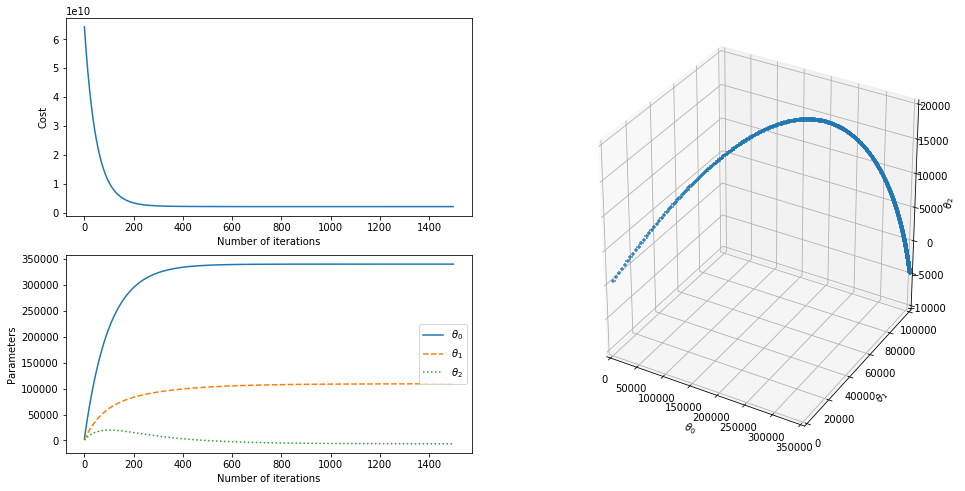

In [13]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
# パラメータ更新ごとのコストをプロット
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
# 更新ごとのパラメータを更新数の関数としてプロット
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
# 更新に伴うパラメータの動きをパラメータ空間上にプロット
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')
ax3.set_xlim([0,350000])
ax3.set_ylim([0,100000])
ax3.set_zlim([-10000,20000])

## 正規方程式による求解，勾配法との比較，予測

ここまでは勾配法を用いて最適パラメータを求めたが，線形回帰のコスト関数はパラメータの2次式なのでその勾配は1次式であり，勾配消失点は連立1次方程式の解として厳密に求まる．実際，勾配消失条件は
$$
0=\frac{\partial J(\theta )}{\partial\theta} =\frac{1}{m} X^\mathrm{T} (X\theta -y)\iff\theta =(X^\mathrm{T} X)^{-1} X^\mathrm{T} y
$$
のように書き換えられ，最適パラメータ$\theta$が求まることがわかる．なお，正規方程式を用いて最適パラメータを求める場合，特徴量を規格化する必要はない．

In [14]:
# 正規方程式の求解
def normalEq(X,y):
    theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
    return(theta)

In [15]:
X_unnorm = add1column(X_unnorm_unext)

In [16]:
# 正規方程式による最適パラメータの計算
theta_ne = normalEq(X_unnorm,y)
print('正規方程式で得られた最適パラメータ theta =',theta_ne.flatten())

正規方程式で得られた最適パラメータ theta = [89597.9095428    139.21067402 -8738.01911233]


特徴量の規格化をしていないため，勾配法を用いたときとはパラメータの値が異なることに注意されたい．しかし，規格化後の特徴量による仮設の式$h_\theta (x^{(d)})=(x^{(d)})^\mathrm{T} \theta$は，規格化前の特徴量で表しても（すなわち$x_j^{(d)}$を改めて$(x_j^{(d)} -\mu _j）/\sigma _j$と書いても），$x_j^{(d)}$の1次式であることには変わりないので，規格化の前後で「$\{ x_j^{(d)} \} _{j=1,\dots ,n}$の1次式と$y^{(d)}$の2乗誤差を小さくするように1次式の係数を決める」という点は同じである．したがって，最小化されたコストの値は規格化の有無によらないはずである．

実際に，勾配法の更新に伴うコストの動きを，正規方程式で得られた厳密な最適パラメータにおけるコストと比較する．すると，勾配法の更新とともにコストが最適値に収束し，その最適値は正規方程式から求めたものとほぼ一致していることがわかる．

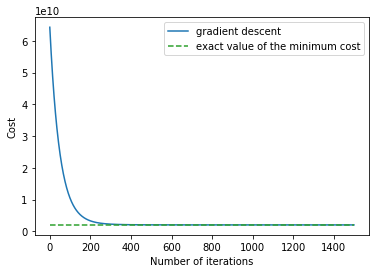

In [17]:
# 最小コストの厳密値
J_ne = computeCost(X_unnorm,y,theta_ne)

# パラメータ更新ごとのコストをプロット
plt.plot(J_history,label='gradient descent')
plt.plot(np.linspace(0,1500),J_ne*np.ones((50)),'--',color='#2ca02c',label='exact value of the minimum cost')
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.legend()

予測の例として，サイズが$1,650\,\mathrm{feet}^2$，寝室数が3のときの家の価格を予測する．確かに，勾配法と正規方程式は近い値を返す．

In [18]:
# 価格の予測
print('勾配法：',np.hstack((np.array([1]), (np.array([1650,3]) - mu) / sigma)).dot(theta_gd))
print('正規方程式：',np.array([1,1650,3]).dot(theta_ne))

勾配法： [293098.46667577]
正規方程式： [293081.4643349]


## 学習率の調整

上記の勾配法の実装では学習率を$\alpha =0.01$，更新回数を1,500としたが，学習率を変えると勾配法の振る舞いがどのように変わるのかを観察する．

まず$\alpha =0.1$としてみると，100ステップ程度で収束する．

勾配法実行後のパラメータ theta = [340403.61773803 108803.37852266  -5933.9413402 ]


(-10000, 20000)

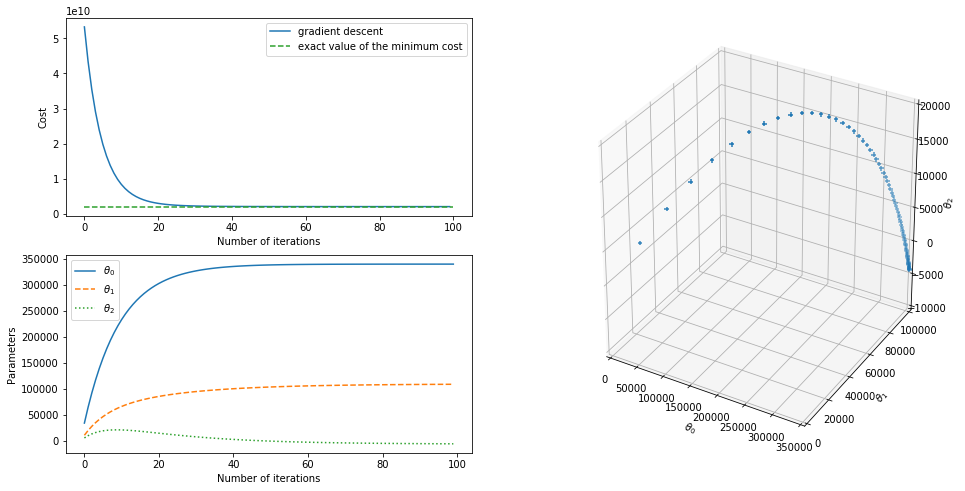

In [19]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X_norm,y,thetai,alpha=0.1,num_iters=100)
print('勾配法実行後のパラメータ theta =',theta_gd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history,label='gradient descent')
ax1.plot(np.linspace(0,100),J_ne*np.ones((50)),'--',color='#2ca02c',label='exact value of the minimum cost')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax1.legend()
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')
ax3.set_xlim([0,350000])
ax3.set_ylim([0,100000])
ax3.set_zlim([-10000,20000])

さらに学習率を大きくして$\alpha =1$とすると，20ステップ程度で収束するが，初めパラメータが振動するのでもう少し学習率が小さい方がよいと思われる．

勾配法実行後のパラメータ theta = [340412.65957447 109446.79079183  -6578.29440794]


(-10000, 20000)

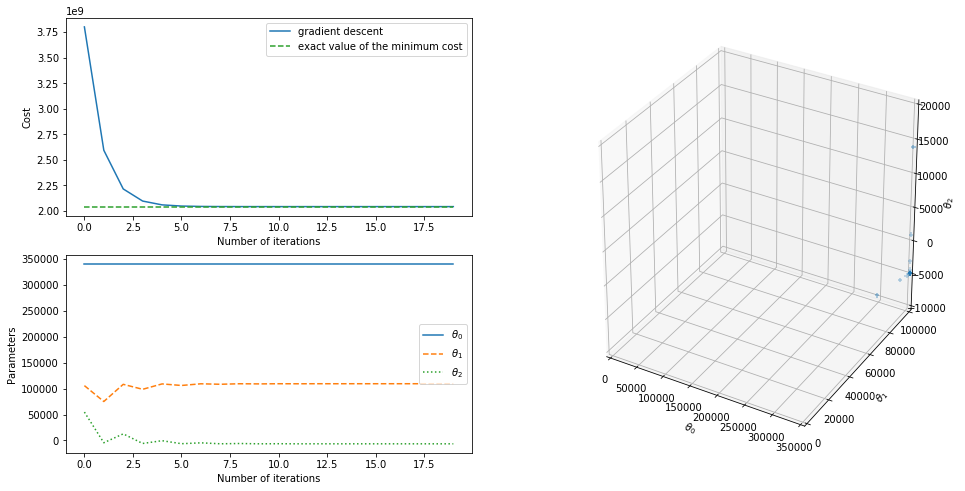

In [20]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X_norm,y,thetai,alpha=1,num_iters=20)
print('勾配法実行後のパラメータ theta =',theta_gd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history,label='gradient descent')
ax1.plot(np.linspace(0,19),J_ne*np.ones((50)),'--',color='#2ca02c',label='exact value of the minimum cost')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax1.legend()
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')
ax3.set_xlim([0,350000])
ax3.set_ylim([0,100000])
ax3.set_zlim([-10000,20000])

$\alpha =0.7$とすると，パラメータは振動せず，20ステップ程度で収束する．

勾配法実行後のパラメータ theta = [340412.6595626  109411.03781376  -6541.59619828]


(-10000, 20000)

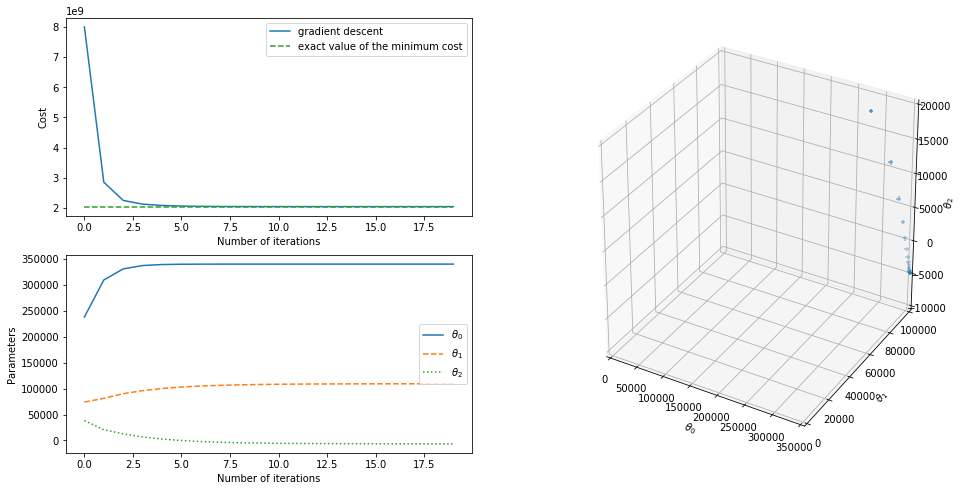

In [21]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X_norm,y,thetai,alpha=0.7,num_iters=20)
print('勾配法実行後のパラメータ theta =',theta_gd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history,label='gradient descent')
ax1.plot(np.linspace(0,19),J_ne*np.ones((50)),'--',color='#2ca02c',label='exact value of the minimum cost')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax1.legend()
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')
ax3.set_xlim([0,350000])
ax3.set_ylim([0,100000])
ax3.set_zlim([-10000,20000])

一方，$\alpha =2$とするとコストが指数発散してしまう．

勾配法実行後のパラメータ theta = [-4.38885763e-08 -9.41838069e+07 -9.42998330e+07]


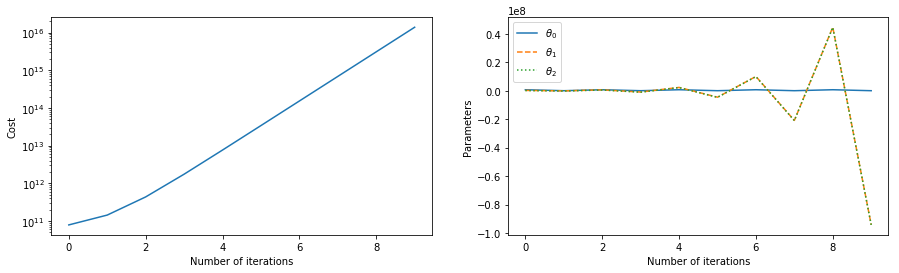

In [22]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X_norm,y,thetai,alpha=2,num_iters=10)
print('勾配法実行後のパラメータ theta =',theta_gd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.semilogy(J_history) # コストを片対数プロット
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = fig.add_subplot(122)
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()

以上の考察から，最適な学習率は約$\alpha =0.7$だと言える．

## 特徴量を規格化しなかった場合の勾配法

これまでは規格化した特徴量を用いて勾配法を実行してきた．以下では規格化されていない特徴量を用いて勾配法を行い，非常に性能が悪くなることを見る．

規格化していない特徴量を用いた場合，学習率をかなり小さくしてもコストが発散してしまう．例えば学習率$\alpha =10^{-6}$でさえ勾配法は収束しない．

勾配法実行後のパラメータ theta = [4.46848599e+01 1.03095506e+05 1.48987076e+02]


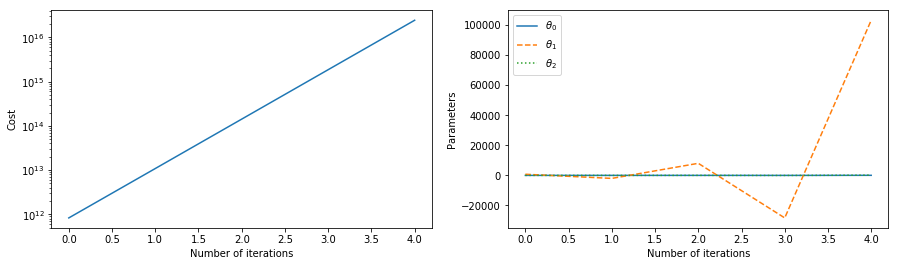

In [23]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X_unnorm,y,thetai,alpha=1e-6,num_iters=5)
print('勾配法実行後のパラメータ theta =',theta_gd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.semilogy(J_history) # コストを片対数プロット
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = fig.add_subplot(122)
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()

学習率を$\alpha =10^{-7}$とするとコストは一見収束しているように見えるが，厳密なコストの最小値とのずれが残る．また，勾配法実行後に得られるパラメータの値を正規方程式で求めたパラメータの最適値と比べると，大きく異なることがわかる．

勾配法実行後のパラメータ theta = [9.06724623e-02 1.65382111e+02 2.72059235e-01]


(0, 0.3)

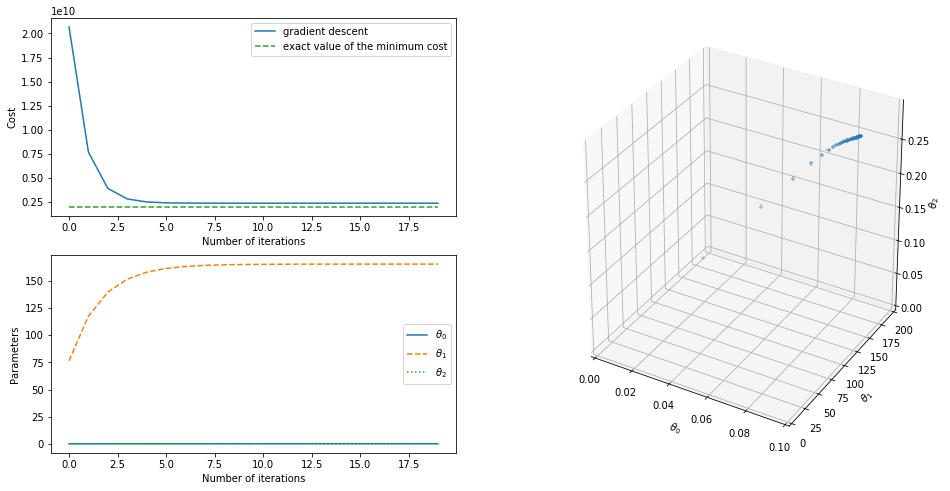

In [24]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X_unnorm,y,thetai,alpha=1e-7,num_iters=20)
print('勾配法実行後のパラメータ theta =',theta_gd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history,label='gradient descent')
ax1.plot(np.linspace(0,19),J_ne*np.ones((50)),'--',color='#2ca02c',label='exact value of the minimum cost')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax1.legend()
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')
ax3.set_xlim([0,0.1])
ax3.set_ylim([0,200])
ax3.set_zlim([0,0.3])

さらに学習率を小さくして$\alpha =10^{-10}$とし，20,000ステップ更新する．この場合も勾配法実行後のコストの値は，特徴量の規格化を行った場合と比べ，厳密な最小値とずれている．加えて，勾配法実行後のパラメータはやはり正規方程式から得られる値と大きく異なっている．

勾配法実行後のパラメータ theta = [9.06658316e-02 1.65366798e+02 2.72037116e-01]


(0, 0.3)

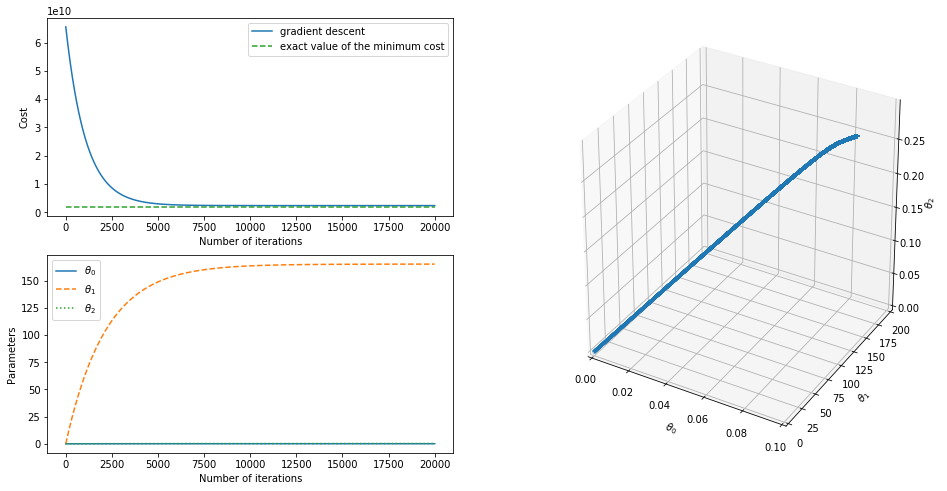

In [25]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X_unnorm,y,thetai,alpha=1e-10,num_iters=20000)
print('勾配法実行後のパラメータ theta =',theta_gd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history,label='gradient descent')
ax1.plot(np.linspace(0,20000),J_ne*np.ones((50)),'--',color='#2ca02c',label='exact value of the minimum cost')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax1.legend()
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')
ax3.set_xlim([0,0.1])
ax3.set_ylim([0,200])
ax3.set_zlim([0,0.3])

このように特徴量を規格化しておかないと勾配法が正しく収束しないのは，大きなスケールを持つ特徴量に対応するパラメータだけが仮設に寄与してしまい，他のパラメータが初期値からほとんど動かなくなるからである．今扱っている問題では，初めの訓練データのプロットを見ればわかる通り，$x_0 =1$, $x_1 \sim 10^3$, $x_2 \sim 10^0$なので，仮設の式$h_\theta (x)=\theta ^0 +\theta ^1 x_1 +\theta ^2 x_2$において$\theta ^1 x_1$の項だけが効いてしまう．$\theta ^0$や$\theta ^2 x_2$の項が$\theta ^1 x_1$と同程度のオーダーになるためには$\theta ^0$と$\theta ^2$が非常に大きくならなければならない（実際パラメータの最適値は，$\theta ^1 \sim 10^2$であるのに対し$\theta ^0 \sim 10^5$, $\theta ^2 \sim 10^4$である）．しかし，初期値として$\theta =0$をとっているので，$\theta ^0$と$\theta ^2$が大きくなるのは難しいことがわかるだろう．

以上の考察から，線形回帰で勾配法を用いる場合，前処理としてデータの特徴量を規格化しておくのが重要であることがわかる．

## 自然勾配法

線形回帰における自然勾配法の更新式は
$$
\theta\leftarrow (1-\alpha )\theta +\alpha\theta ^*
$$
で与えられる（自然勾配法については[1変数線形回帰](https://github.com/MCMXCIII-KVK/Coursera_Machine_Learning/blob/master/ex1_py/ex1_1.ipynb)の自然勾配法の節を参照）．ただし，$\theta ^* =(X^\mathrm{T} X)^{-1} X^\mathrm{T} y$は正規方程式の解である．

In [26]:
# 自然勾配法
def naturalGradientDescent(X,y,thetai,alpha=0.01,num_iters=1500):
    theta = thetai
    theta_history = thetai * np.ones(num_iters)
    J_history = np.zeros(num_iters)
    theta_ne = normalEq(X,y)
    
    for i in np.arange(num_iters):
        theta = (1 - alpha) * theta + alpha * theta_ne
        theta_history[:,[i]] = theta
        J_history[i] = computeCost(X,y,theta)
    
    return(theta,theta_history,J_history)

勾配法と自然勾配法を学習率$\alpha =0.01$，更新回数1,500で実行し，コストとパラメータの動きを比較する．両者のアルゴリズムにおいてコストの差は視認できないが，パラメータの時間変化を見ると，自然勾配法の方が早く（800ステップ程度で）収束していることがわかる．また，勾配法のダイナミクスはパラメータ空間上で曲線を描いているのに対し，自然勾配法は直線を描いていることがわかる．

勾配法実行後のパラメータ theta = [340412.56301439 109370.05670466  -6500.61509507]
自然勾配法実行後のパラメータ theta = [340412.56301439 109447.76542412  -6578.35298817]


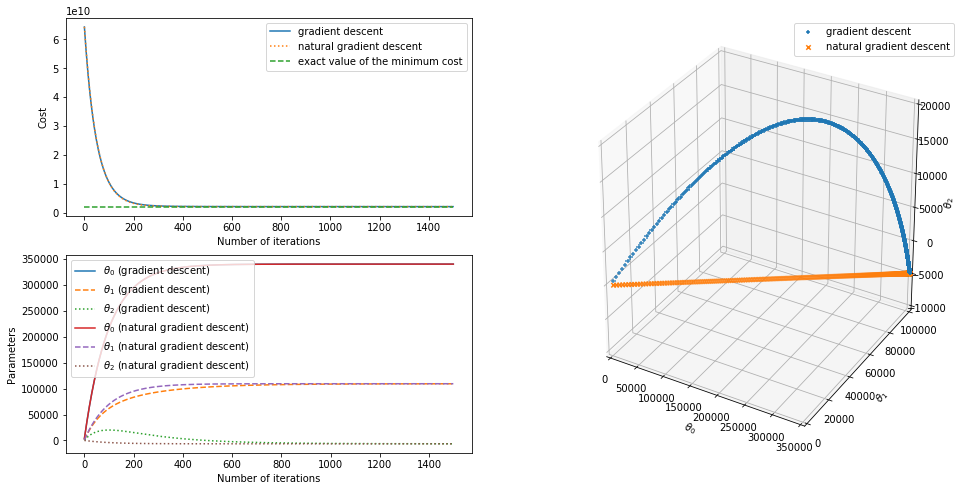

In [27]:
# 勾配法の実行
theta_gd, theta_history, J_history = gradientDescent(X_norm,y,thetai)
print('勾配法実行後のパラメータ theta =',theta_gd.flatten())
# 自然勾配法の実行
theta_ngd, theta_nhistory, J_nhistory = naturalGradientDescent(X_norm,y,thetai)
print('自然勾配法実行後のパラメータ theta =',theta_ngd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_history,'-',label='gradient descent')
ax1.plot(J_nhistory,':',label='natural gradient descent')
ax1.plot(np.linspace(0,1500),J_ne*np.ones((50)),'--',color='#2ca02c',label='exact value of the minimum cost')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax1.legend()
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_history[0,:],'-',label=r'$\theta_0$ (gradient descent)')
ax2.plot(theta_history[1,:],'--',label=r'$\theta_1$ (gradient descent)')
ax2.plot(theta_history[2,:],':',label=r'$\theta_2$ (gradient descent)')
ax2.plot(theta_nhistory[0,:],'-',label=r'$\theta_0$ (natural gradient descent)')
ax2.plot(theta_nhistory[1,:],'--',label=r'$\theta_1$ (natural gradient descent)')
ax2.plot(theta_nhistory[2,:],':',label=r'$\theta_2$ (natural gradient descent)')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_history[0,:],theta_history[1,:],theta_history[2,:],marker='+',label='gradient descent')
ax3.scatter3D(theta_nhistory[0,:],theta_nhistory[1,:],theta_nhistory[2,:],marker='x',label='natural gradient descent')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')
ax3.set_xlim([0,350000])
ax3.set_ylim([0,100000])
ax3.set_zlim([-10000,20000])
ax3.legend()

さらに，自然勾配法は特徴量を規格化しなくても用いることができる．

自然勾配法実行後のパラメータ theta = [89569.03909268   139.16581723 -8735.20352716]


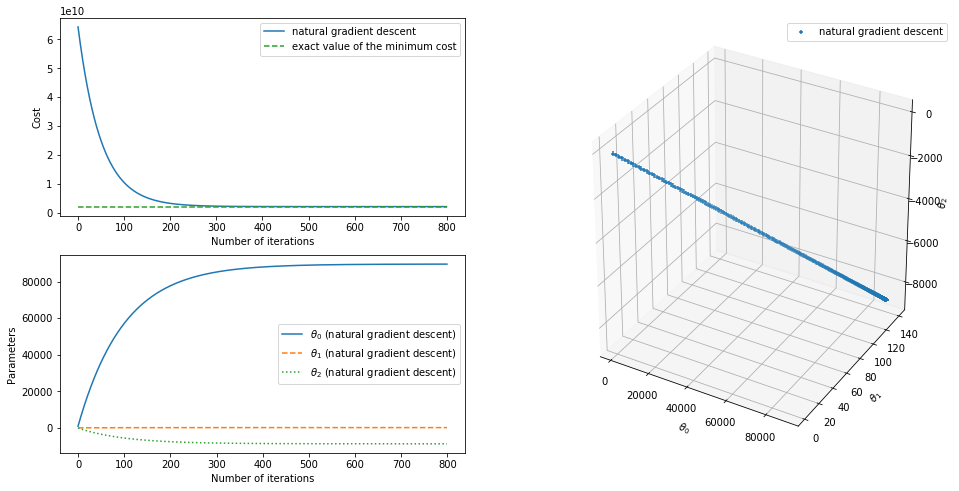

In [28]:
# 自然勾配法の実行
theta_ngd, theta_nhistory, J_nhistory = naturalGradientDescent(X_unnorm,y,thetai,num_iters=800)
print('自然勾配法実行後のパラメータ theta =',theta_ngd.flatten())

# パラメータ更新ごとのコスト，パラメータをプロット
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(J_nhistory,label='natural gradient descent')
ax1.plot(np.linspace(0,800),J_ne*np.ones((50)),'--',color='#2ca02c',label='exact value of the minimum cost')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax1.legend()
ax2 = plt.subplot(gs[1,0])
ax2.plot(theta_nhistory[0,:],'-',label=r'$\theta_0$ (natural gradient descent)')
ax2.plot(theta_nhistory[1,:],'--',label=r'$\theta_1$ (natural gradient descent)')
ax2.plot(theta_nhistory[2,:],':',label=r'$\theta_2$ (natural gradient descent)')
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax2.legend()
ax3 = plt.subplot(gs[:,1],projection='3d')
ax3.scatter3D(theta_nhistory[0,:],theta_nhistory[1,:],theta_nhistory[2,:],marker='+',label='natural gradient descent')
ax3.set_xlabel(r'$\theta _0$')
ax3.set_ylabel(r'$\theta _1$')
ax3.set_zlabel(r'$\theta _2$')
ax3.legend()